# Deep Dynamic Network

## Define model and function to add noise to input

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [ ]:
# Function to generate random noise
def generate_noise(num_noise_inputs):
    return np.random.rand(num_noise_inputs)  # Random values between 0 and 1 for noise

# Define the Frozen Lake environment
states = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
num_states = len(states)
num_actions = 4

# Define the transition matrix
R = np.array([
    ['A', 'E', 'B', 'A'],
    ['B', 'F', 'C', 'A'],
    ['C', 'G', 'D', 'B'],
    ['D', 'H', 'D', 'C'],
    ['A', 'I', 'F', 'E'],
    ['B', 'J', 'G', 'E'],
    ['C', 'K', 'H', 'F'],
    ['D', 'L', 'H', 'G'],
    ['E', 'M', 'J', 'I'],
    ['F', 'N', 'K', 'I'],
    ['G', 'O', 'L', 'J'],
    ['H', 'P', 'L', 'K'],
    ['I', 'M', 'N', 'M'],
    ['J', 'N', 'O', 'M'],
    ['K', 'O', 'P', 'N'],
    ['L', 'P', 'P', 'O']
])
listOfHoles = np.array(['F', 'H', 'L', 'M'])

# Convert states to one-hot encoded vectors, ie: state A: (1, 0, 0, 0, 0, ... 0)
def state_to_one_hot(state):
    one_hot = np.zeros(num_states)
    one_hot[states.index(state)] = 1
    return one_hot

In [ ]:
# Define the number of noise inputs
num_noise_inputs = 10  # 10 additional noise inputs
total_inputs = num_states + num_noise_inputs  # Total input size (original inputs + noise)

# Define the model that accepts both state input and noise input
model = tf.keras.Sequential([
    layers.Input(shape=(total_inputs,)),  # Input size is 26 (16 original + 10 random)
    layers.Dense(32, activation='tanh'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

## Trained model with noisy input

In [ ]:
import time  # Import the time module

In [ ]:
import time
import numpy as np

# Hyperparameters
gamma = 0.9
num_iterations = 200
epsilon = 0.1
evaluation_interval = 2  # Evaluate every 20 iterations

# Store reward history for plotting or analysis
reward_history = []

start_time = time.time()  # Record the start time

# Function to evaluate the policy's rewards
def evaluate_policy(network, noise_size=10):
    total_reward = 0
    for state in states:
        state_index = states.index(state)
        state_vector = state_to_one_hot(state)

        # Generate random noise and concatenate to the state vector
        noise_vector = generate_noise(num_noise_inputs)
        noisy_state_vector = np.concatenate([state_vector, noise_vector]) # vector for A: (1,0,0,..., 16th,[random])

        # Next state vectors for all actions with noise
        next_state_vectors = np.array(
            [np.concatenate([state_to_one_hot(R[state_index][a]), generate_noise(num_noise_inputs)])for a in range(num_actions)])

        # Predict the values of all possible next states (with noisy inputs)
        next_state_values = network.predict(next_state_vectors)

        # Predict the best action using the noisy input
        #action_values = network.predict(noisy_state_vector.reshape(1, -1))
        best_action = np.argmax(next_state_values)

        # Determine the next state based on the chosen action
        next_state = R[states.index(state)][best_action]

        # Reward calculation based on the next state
        reward = 0
        if next_state == 'P':
          reward = 1
        if next_state in listOfHoles:
          reward = -10

        total_reward += reward

        # Append total reward for this episode
        #rewards.append(total_reward)
        if next_state == 'P':
          break;

    return total_reward

# Training loop with evaluation every 20 iterations
for iteration in range(num_iterations):
    for state in states:
        state_index = states.index(state)
        state_vector = state_to_one_hot(state)

        # Generate random noise and concatenate to the state vector
        noise_vector = generate_noise(num_noise_inputs)
        noisy_state_vector = np.concatenate([state_vector, noise_vector])

        # Next state vectors for all actions with noise
        next_state_vectors = np.array([
            np.concatenate([state_to_one_hot(R[state_index][a]), generate_noise(num_noise_inputs)])
            for a in range(num_actions)
        ])

        # Predict the values of all possible next states (with noisy inputs)
        next_state_values = model.predict(next_state_vectors)

        # Calculate the target value using the Bellman equation
        target_value = -float('inf')
        for a in range(num_actions):
            next_state = R[state_index][a]

            # Reward calculation
            reward = 0
            if state == 'P':
                reward = 1
            if state in listOfHoles:
                reward = -10

            # Calculate the target value for each action
            value = reward + gamma * next_state_values[a]
            target_value = max(target_value, value)

        # Train the model to output the target value for the current state (with noisy input)
        model.fit(noisy_state_vector.reshape(1, -1), np.array([target_value]), epochs=1, verbose=0)

    # Evaluate the policy every 2 iterations
    if iteration % evaluation_interval == 0:
        policy_reward = evaluate_policy(model, noise_size=num_noise_inputs)
        reward_history.append(policy_reward)
        print(f"Iteration {iteration}: Evaluated reward = {policy_reward}")

# End timing
end_time = time.time()  # Record the end time

# Calculate the total training time
training_time = end_time - start_time

# Print the training time
print(f"Total training time: {training_time:.2f} seconds")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━

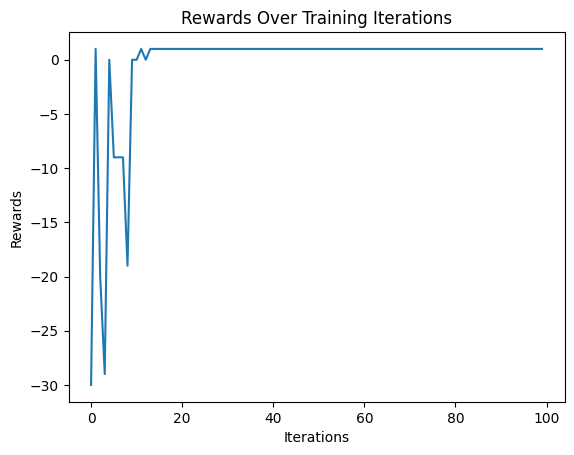

In [ ]:
import matplotlib.pyplot as plt

# Assume reward_history contains the rewards at intervals
evaluation_intervals = range(0, num_iterations, evaluation_interval)

# Plot the rewards over the training iterations
plt.plot(reward_history)

# Add labels and title to the plot
plt.xlabel('Iterations')
plt.ylabel('Rewards')
plt.title('Rewards Over Training Iterations')

# Optional: Display the grid
#plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# After training, print out the state values for all states
print("\nFinal State Values After Training:")
for state in states:
    state_vector = state_to_one_hot(state)
    noise_vector = np.random.random(10)  # Add the same 10-dimensional noise vector
    noisy_state_vector = np.concatenate([state_vector, noise_vector])

    # Predict the value for the noisy state
    state_value = model.predict(noisy_state_vector.reshape(1, -1), verbose=0)

    print(f"State: {state}, Value: {state_value[0][0]}")


Final State Values After Training:
State: A, Value: 5.434552192687988
State: B, Value: 6.266460418701172
State: C, Value: 6.918808937072754
State: D, Value: 5.979236125946045
State: E, Value: 6.379303455352783
State: F, Value: -2.5214240550994873
State: G, Value: 7.668067455291748
State: H, Value: -3.1224491596221924
State: I, Value: 7.311178207397461
State: J, Value: 7.7724809646606445
State: K, Value: 8.549370765686035
State: L, Value: -0.3252355754375458
State: M, Value: -2.343310594558716
State: N, Value: 8.932121276855469
State: O, Value: 9.810202598571777
State: P, Value: 10.492809295654297


# Reduced Network: Use the activations of the first hidden layer as input

In [ ]:
# Step 1: Freeze the layers of the original model
for layer in model.layers:
    layer.trainable = False

In [ ]:
for layer in model.layers:
    print(layer.name)

dense
dense_1
dense_2
dense_3


In [ ]:
# Assuming your original model structure is something like this:
#input_layer = layers.Input(shape=(total_inputs,))
first_hidden_layer_output = model.get_layer('dense').output

# Create the feature extraction model

feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=first_hidden_layer_output)
# Create dummy data
dummy_input = np.random.random((1, 26))

# Predict features using the feature extractor
try:
    features = feature_extractor.predict(dummy_input)
    print("Feature extraction successful. Output shape:", features.shape)
except Exception as e:
    print("Error during feature extraction:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Feature extraction successful. Output shape: (1, 32)


In [ ]:
# Extract features for each state after training
state_features_dict = {}
print("\nExtracted Features for Each State:")

for state in states:
    # One-hot encode the state and add noise
    state_vector = state_to_one_hot(state)
    noise_vector = np.random.random(10)
    noisy_state_vector = np.concatenate([state_vector, noise_vector])

    # Use the feature extractor model to get the features
    extracted_features = feature_extractor.predict(noisy_state_vector.reshape(1, -1), verbose=0)
    state_features_dict[state] = extracted_features.reshape(-1)

    #print(f"State: {state}, Extracted Features:\n {extracted_features}")


Extracted Features for Each State:


In [ ]:
# convert to 0 & 1
for state, features in state_features_dict.items():
    state_features_dict[state] = np.where(features > 0, 1, 0)

In [ ]:
for state in states:
    print(state_features_dict[state])

[1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 0 0 1 1 1]
[1 1 0 0 1 0 1 1 1 1 1 0 1 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 0 0 0]
[1 1 1 0 0 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 0]
[1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 1 1]
[1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 0 1 0 1 0 1 1 0 0]
[1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0]
[1 1 0 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1]
[1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 1 1 1]
[1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 0 1 0 0 0 0 0]
[1 1 0 1 0 0 1 1 1 1 1 0 1 1 0 0 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 0]
[1 1 0 0 0 1 1 1 0 1 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 0 0 1 1 0]
[1 1 0 1 1 1 1 0 1 1 0 0 1 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0]
[1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 0 1 1]
[1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 0 0 1 0 1 1 0 1 1 0 1 1 0 0 1 0 1]
[1 1 1 0 1 1 1 0 1 1 1 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 0 0 0 1 0 0]
[1 0 1 0 0

# A reduced sequential model with 2 hidden layer of 32

In [ ]:
# Define a new model using the extracted features
new_model_3 = tf.keras.Sequential([
    layers.Input(shape=(32,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

new_model_3.compile(optimizer='adam', loss='mse')

In [ ]:
# Function to evaluate the policy's rewards
def evaluate_policy_fe(network, noise_size=10):
    total_reward = 0
    for state in states:
        state_index = states.index(state)
        state_features = state_features_dict[state].reshape(1, -1)  # Ensure correct shape

        # Predict the values of all possible next states
        next_state_features = np.array([state_features_dict[R[state_index][a]].reshape(1, -1) for a in range(num_actions)])
        next_state_features = np.vstack(next_state_features)  # Stack to shape (num_actions, 32)

        next_state_values = network.predict(next_state_features)

        # Predict the best action using the noisy input
        #action_values = network.predict(noisy_state_vector.reshape(1, -1))
        best_action = np.argmax(next_state_values)

        # Determine the next state based on the chosen action
        next_state = R[states.index(state)][best_action]

        # Reward calculation based on the next state
        reward = 0
        if next_state == 'P':
          reward = 1
        if next_state in listOfHoles:
          reward = -10

        total_reward += reward

        # Append total reward for this episode
        #rewards.append(total_reward)
        if next_state == 'P':
          break;

    return total_reward

In [ ]:
# Training loop
# Store reward history for plotting or analysis
reward_history2 = []
start_time2 = time.time()  # Record the start time
for iteration in range(200):
    for state in states:
        state_index = states.index(state)
        state_features = state_features_dict[state].reshape(1, -1)  # Ensure correct shape

        # Predict the values of all possible next states
        next_state_features = np.array([state_features_dict[R[state_index][a]].reshape(1, -1) for a in range(num_actions)])
        next_state_features = np.vstack(next_state_features)  # Stack to shape (num_actions, 32)

        next_state_values = new_model_3.predict(next_state_features)

        # Calculate the target value using the Bellman equation
        target_value = -float('inf')
        for a in range(num_actions):
            next_state = R[state_index][a]

            # Reward calculation
            reward = 0
            if state == 'P':
                reward = 1
            if state in listOfHoles:
                reward = -10

            # Calculate the target value for each action
            value = reward + gamma * next_state_values[a]
            target_value = max(target_value, value)

        # Train the new model to output target value for the current state
        new_model_3.fit(state_features, np.array([target_value]), epochs=1, verbose=0)

        # Evaluate the policy every 2 iterations
    if iteration % evaluation_interval == 0:
        policy_reward2 = evaluate_policy_fe(new_model_3, noise_size=num_noise_inputs)
        reward_history2.append(policy_reward2)
        print(f"Iteration {iteration}: Evaluated reward = {policy_reward2}")

# End timing
end_time2 = time.time()  # Record the end time

# Calculate the total training time
training_time2 = end_time2 - start_time2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

In [ ]:
# Print the training time
print(f"Total training time: {training_time2:.2f} seconds")

Total training time: 764.62 seconds


In [ ]:
# Print out each reward for both
print("Rewards collected during evaluation for original:")

for i, reward in enumerate(reward_history):
    print(f"Evaluation {i + 1}: Reward = {reward}")

print("\n")
print("\n")

print("Rewards collected during evaluation for feature extraction:")
for i, reward in enumerate(reward_history2):
    print(f"Evaluation {i + 1}: Reward = {reward}")

Rewards collected during evaluation for original:
Evaluation 1: Reward = -30
Evaluation 2: Reward = 1
Evaluation 3: Reward = -20
Evaluation 4: Reward = -29
Evaluation 5: Reward = 0
Evaluation 6: Reward = -9
Evaluation 7: Reward = -9
Evaluation 8: Reward = -9
Evaluation 9: Reward = -19
Evaluation 10: Reward = 0
Evaluation 11: Reward = 0
Evaluation 12: Reward = 1
Evaluation 13: Reward = 0
Evaluation 14: Reward = 1
Evaluation 15: Reward = 1
Evaluation 16: Reward = 1
Evaluation 17: Reward = 1
Evaluation 18: Reward = 1
Evaluation 19: Reward = 1
Evaluation 20: Reward = 1
Evaluation 21: Reward = 1
Evaluation 22: Reward = 1
Evaluation 23: Reward = 1
Evaluation 24: Reward = 1
Evaluation 25: Reward = 1
Evaluation 26: Reward = 1
Evaluation 27: Reward = 1
Evaluation 28: Reward = 1
Evaluation 29: Reward = 1
Evaluation 30: Reward = 1
Evaluation 31: Reward = 1
Evaluation 32: Reward = 1
Evaluation 33: Reward = 1
Evaluation 34: Reward = 1
Evaluation 35: Reward = 1
Evaluation 36: Reward = 1
Evaluation 3

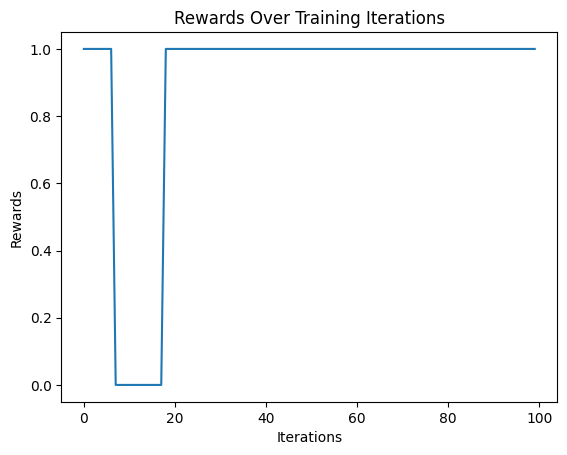

In [ ]:
# Plot the rewards over the training iterations
plt.plot(reward_history2)

# Add labels and title to the plot
plt.xlabel('Iterations')
plt.ylabel('Rewards')
plt.title('Rewards Over Training Iterations')

# Optional: Display the grid
#plt.grid(True)

# Show the plot
plt.show()

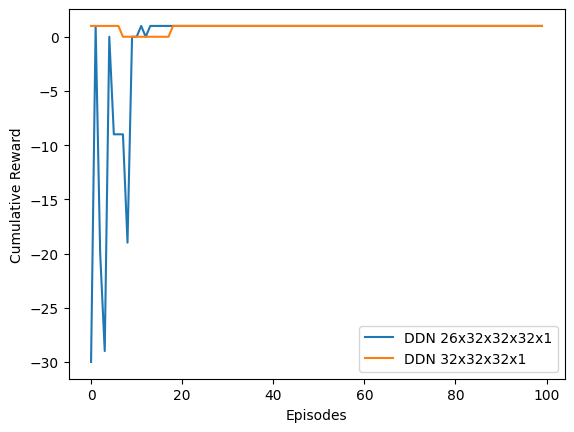

In [ ]:
# Plot the comparison
plt.plot(reward_history, label='DDN 26x32x32x32x1')
plt.plot(reward_history2, label='DDN 32x32x32x1')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
#plt.title('Deep Dynamic Network vs Feature Extraction Network Performance (With Noise)')
plt.legend()
plt.show()

In [ ]:
# Predict V values for all states
v_values = {}
for state, features in state_features_dict.items():
    features_reshaped = features.reshape(1, -1)  # Ensure correct shape
    v_value = new_model_3.predict(features_reshaped)
    v_values[state] = v_value[0][0]  # Extract the scalar value

# Print V values for each state
for state in states:
    print(f"State: {state}, V-value: {v_values[state]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
State: A, V-value: 5.314855575561523
State: B, V-value: 5.904721736907959
State: C, V-value: 6.560756206512451
State: D, V-value: 5.904695510864258
State: E, V-value: 5.9050421714782715
State: F, V-value: -3.438866376876831
State: G, V-value: 7.289700984954834
State: H, V-value: -3.439258575439453
State: I, V-value: 6.561029434204102
State: J, V-value: 7.290068626403809
State: K, V-value: 